In [1]:
#@title Aprendizaje Profundo | Otoño 2021 by Datitos{display-mode: "form" }
#@markdown ![71335171.png](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAMgAAADICAIAAAAiOjnJAAACwElEQVR4nOzdMY7iQBBA0WU197/FnJNNJ/FqWvLHZfd7McIGfVVQos3X+/3+A2f7e/UN8EzCIiEsEsIiISwSwiIhLBLCIiEsEsIiISwSwiIhLBLCIiEsEsIiISwSwiIhLBLCIiEsEsIiISwSwiIhLBLCIiEsEsIiISwSwiIhLBLCIiEsEsIiISwSwiIhLBLCIiEsEsIiISwSwiIhLBJfV9/A/7xer6XX3/1/gZ70eU0sEsIiISwSwiIhLBLCIiEsEiP2WEf7m9U9zVnvU9vh85pYJIRFQlgkhEVCWCSERUJYJEbssc5ytL+5at8zec9UM7FICIuEsEgIi4SwSAiLhLBIPGqPdWR1v1VfdwcmFglhkRAWCWGREBYJYZEQFokt9lhHdt4z1UwsEsIiISwSwiIhLBLCIiEsEh/dY+18zq4w7RzlTyYWCWGREBYJYZEQFglhkRAWiS1+jzVhr/Mbd7nP3zCxSAiLhLBICIuEsEgIi4SwSDxqj1U/72r1ulc9l2sCE4uEsEgIi4SwSAiLhLBICIvE7D3W9/fSy6/63dLqdZfvc/F7mMDEIiEsEsIiISwSwiIhLBLCIjF7j3WSs87rTXufyUwsEsIiISwSwiIhLBLCIiEsEq8Ju5N6r3OXc3xP2oeZWCSERUJYJIRFQlgkhEVCWCRG7LGOTN7TfNIdvwcTi4SwSAiLhLBICIuEsEgIi8Toc4U7Pyf9p8n7qiMmFglhkRAWCWGREBYJYZEQFonRe6wjd9zr7MbEIiEsEsIiISwSwiIhLBLCIiEsEsIiISwSwiIhLBLCIiEsEsIiISwSwiIhLBLCIiEsEsIiISwSwiIhLBLCIiEsEsIiISwSwiIhLBLCIiEsEsIiISwSwiIhLBLCIiEsEsIiISwSwiIhLBLCIiEsEsIiISwSwiIhLBLCIiEsEsIi8S8AAP//HtRtH09JwIEAAAAASUVORK5CYII=)
#El siguiente notebook fue traducido por Pablo Marinozi como el quinto trabajo práctico correspondiente a la versión de Otoño del 2021 del curso Aprendizaje Profundo organizado por Datitos
#El trabajo original fue diseñado por los docentes de la CS231n: Convolutional Neural Networks for Visual Recognition de la Universidad de Stanford. http://cs231n.stanford.edu
#Para mayor información consultar https://datitos.github.io/curso-aprendizaje-profundo/#calendario

# Trabajo Práctico N° 5. Opción 1: Transferencia de Estilos
En este notebook implementaremos la técnica de transferencia de estilo de ["Image Style Transfer Using Convolutional Neural Networks" (Gatys et al., CVPR 2015)](http://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf).

La idea general es tomar dos imágenes y producir una nueva imagen que refleje el contenido de una pero el "estilo" artístico de la otra. Haremos esto formulando primero una función de pérdida que coincida con el contenido y el estilo de cada imagen respectiva en el espacio de características de una red profunda, y luego realizando un descenso de gradiente en los píxeles de la imagen en sí.

La red profunda que usamos como extractor de características es SqueezeNet, un modelo pequeño que ha sido entrenado en ImageNet. Podríamos usar cualquier red, pero elegimos SqueezeNet aquí por su pequeño tamaño y eficiencia.

Aquí hay un ejemplo de las imágenes que podrá producir al final de este cuaderno:

![An image](https://i.imgur.com/ZV9CS3q.png)


# Sección 0: Setup

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import PIL

import numpy as np

import matplotlib.pyplot as plt

SQUEEZENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
SQUEEZENET_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)

CHECKS_PATH = None
!gdown https://drive.google.com/uc?id=1K94TyKQQhBt17M89ATiYHC1mK9p3fEav
!gdown https://drive.google.com/uc?id=1Pcd9OhY_ujPGf63CQdC6gkpR8hqXqihw
!unrar x styles.rar

#%matplotlib inline
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
#%load_ext autoreload
#%autoreload 2

Downloading...
From: https://drive.google.com/uc?id=1K94TyKQQhBt17M89ATiYHC1mK9p3fEav
To: /content/style-transfer-checks.npz
100% 66.3k/66.3k [00:00<00:00, 4.45MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Pcd9OhY_ujPGf63CQdC6gkpR8hqXqihw
To: /content/styles.rar
2.12MB [00:00, 33.2MB/s]

UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from styles.rar

Creating    styles                                                    OK
Extracting  styles/composition_vii.jpg                                     9%  OK 
Extracting  styles/muse.jpg                                               41%  OK 
Extracting  styles/starry_night.jpg                                       54% 66% 70%  OK 
Extracting  styles/the_scream.jpg                                         80%  OK 
Extracting  styles/tubingen.jpg                                           93% 99%  OK 
All OK


In [3]:
CHECKS_PATH = 'style-transfer-checks.npz'

assert CHECKS_PATH is not None, "[!] Choose path to style-transfer-checks.npz"

STYLES_FOLDER = CHECKS_PATH.replace('style-transfer-checks.npz', 'styles')

answers = dict(np.load(CHECKS_PATH))


Le proporcionamos algunas funciones auxiliares para manejar imágenes, ya que para este TP estamos lidiando con archivos JPEG reales, no con datos preprocesados como con CIFAR-10.

In [4]:
def preprocess(img, size=512):
    """Preprocesa una imagen PIL JPG para convertirlo en un tensor de Pytorch
        que está listo para usarse como entrada en el modelo de CNN.
        Pasos de preprocesamiento:
            1) Cambiar el tamaño de la imagen (conservando la relación de aspecto) hasta que el lado más corto tenga la longitud "size".
            2) Convertir la imagen PIL en un tensor de Pytorch.
            3) Normalizar la media de los valores de píxeles de la imagen para que sean la media y la desviación
             estandar esperadas por SqueezeNet
            4) Agregar una dimensión de lotes en la primera posición del tensor: es decir el tensor con forma
                (H, W, C) se convertirá en -> (1, H, W, C).
    """
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

In [5]:
def deprocess(img):
    """ "Desprocesa" un tensor de Pytorch de la salida del modelo de CNN para convertirlo
        una imagen PIL JPG que podemos mostrar, guardar, etc.
        Pasos del desprocesamiento:
            1) Eliminar la dimensión del lote en la primera posición accediendo al segmento en el índice 0.
                 Un tensor de forma (1, H, W, C) se convertirá en -> (H, W, C).
            2) Normalizar la desviación estándar: multiplicar cada canal del tensor de salida por 1 / s,
                 antes de escalar por la desviación estándar de SqueezeNet. Sin cambios en la media.
            3) Normalizar la media: restar la media (de ahí la -m) de cada canal del tensor de salida,
                 centrando los elementos de nuevo antes de centrarse en la media de entrada de SqueezeNet.
                 Sin cambios en el std dev.
            4) Cambiar la escala de todos los valores en el tensor para que se encuentren en el intervalo [0, 1] para prepararse para
                 transformándolo en valores de píxeles de imagen.
            5) Convertir el tensor de Pytorch en una imagen PIL.
    """
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=[1.0 / s for s in SQUEEZENET_STD.tolist()]),
        T.Normalize(mean=[-m for m in SQUEEZENET_MEAN.tolist()], std=[1, 1, 1]),
        T.Lambda(rescale),
        T.ToPILImage(),
    ])
    return transform(img)

In [6]:
def rescale(x):
    """ Una función utilizada internamente dentro de "deprocess".
        Cambia la escala de los elementos de x linealmente para que estén en el intervalo [0, 1]
        con los elementos mínimos asignados a 0, y los elementos máximos mapeados a 1.
    """
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled

In [7]:
def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [8]:
def extract_features(x, cnn):
    """
    Utiliza la CNN para extraer características de la imagen de entrada x.

     Entradas:
     - x: un tensor de PyTorch de forma (N, C, H, W) que contiene un minibatch de imágenes que
       se enviará a la CNN.
     - cnn: un modelo de PyTorch que usaremos para extraer características.

     Salidas:
     - features: una lista de características para las imágenes de entrada x extraídas usando el modelo cnn.
       características [i] es un tensor de forma de PyTorch (N, C_i, H_i, W_i); recuerda que características
       de diferentes capas de la red pueden tener diferentes números de canales (C_i) y
       dimensiones espaciales (H_i, W_i).
    """
    features = []
    prev_feat = x
    for i, module in enumerate(cnn._modules.values()):
        next_feat = module(prev_feat)
        features.append(next_feat)
        prev_feat = next_feat
    return features

#por favor ignore las advertencias sobre la inicialización
def features_from_img(imgpath, imgsize, cnn):
    img = preprocess(PIL.Image.open(imgpath), size=imgsize)
    img_var = img.type(dtype)
    return extract_features(img_var, cnn), img_var

Pytorch tiene dos tipos separados de tensores que contienen números de punto flotante: uno para operaciones en la CPU (torch.FloatTensor) y otro que usa CUDA para operaciones en la GPU (torch.cuda.FloatTensor). Usaremos esta variable de tipo más adelante, por lo que debemos establecer el tipo de tensor en uno de ellos.

In [9]:
dtype = torch.FloatTensor
# ¡Descomente la siguiente línea si está en una máquina con una GPU configurada para PyTorch!
#dtype = torch.cuda.FloatTensor

In [10]:
# Carga el modelo SqueezeNet previamente entrenado.
cnn = torchvision.models.squeezenet1_1(pretrained=True).features
cnn.type(dtype)

# No queremos entrenar más el modelo, por lo que no queremos que PyTorch 
# desperdicie recursos al calcular gradientes de parámetros que nunca actualizaremos.
for param in cnn.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-f364aa15.pth


# Sección 1: Cálculo de la Función de Pérdida

Vamos a calcular ahora los tres componentes de nuestra función de pérdida. La función de pérdida es una suma ponderada de tres términos: pérdida de contenido + pérdida de estilo + pérdida total de variación. Vas a completar las funciones que calculan estos términos ponderados a continuación.

## Sección 1A: Pérdida de Contenido

Podemos generar una imagen que refleje el contenido de una imagen y el estilo de otra incorporando ambos en nuestra función de pérdida. Queremos penalizar las desviaciones del contenido con respecto a la imagen de contenido y las desviaciones del estilo con respecto a la imagen de estilo. Luego, podemos usar esta función de pérdida híbrida para realizar un descenso de gradiente no en los parámetros del modelo, sino en los valores de los píxeles de nuestra imagen original.

Primero escribamos la función de pérdida de contenido. La pérdida de contenido mide cuánto difiere el mapa de activación de la imagen generada del mapa de activación de la imagen de origen. Solo nos importa la representación del contenido de una capa de la red (digamos, capa $\ell$), que tiene mapas de activación $A^\ell \in \mathbb{R}^{1 \times C_\ell \times H_\ell \times W_\ell}$. $C_\ell$ es el número de filtros / canales en la capa $\ell$, $H_\ell$ and $W_\ell$ son la altura y el ancho. Vamos a trabajar con versiones remodeladas de estos mapas de características que combinan todas las posiciones espaciales en una dimensión. Sea $F^\ell \in \mathbb{R}^{C_\ell \times M_\ell}$ el mapa de activación de la imagen actual y $P^\ell \in \mathbb{R}^{C_\ell \times M_\ell}$ mapa de activación para la imagen de origen del contenido, donde $M_\ell=H_\ell\times W_\ell$ es el número de elementos en cada mapa de activación. Cada fila de $F^\ell$ or $P^\ell$ representa las activaciones vectorizadas de un filtro particular, convolucionado sobre todas las posiciones de la imagen. Finalmente, sea $w_c$ el peso del término de pérdida de contenido en la función de pérdida.

Entonces la pérdida de contenido viene dada por:

$L_c = w_c \times \sum_{i,j} (F_{ij}^{\ell} - P_{ij}^{\ell})^2$

Implemente la función `content_loss` en la siguiente celda.

In [11]:
def content_loss(content_weight, content_current, content_original):
    """
    Calcule la pérdida de contenido para la transferencia de estilo.

    Entradas:
    - content_weight: Escalar que da la ponderación de la pérdida de contenido.
    - content_current: mapas de activación de la imagen actual; este es un tensor 
    de Pytorch de forma (1, C_l, H_l, W_l).
    - content_target: mapas de activación de la imagen del contenido, tensor con forma (1, C_l, H_l, W_l).

    Devoluciones:
    - escalar que representa la pérdida de contenido 
    """
    # ***** INICIO DE SU CÓDIGO (NO BORRAR / MODIFICAR ESTA LÍNEA) *****

    content_loss = content_weight * torch.sum((content_current - content_original)**2)
    return content_loss

    # ***** FIN DE SU CÓDIGO (NO BORRAR / MODIFICAR ESTA LÍNEA) ***** 


Poné a prueba tu pérdida de contenido. Deberías ver errores inferiores a 0,001.


In [12]:
# content_image = '%s/tubingen.jpg' % (STYLES_FOLDER)
# image_size =  192
# content_layer = 3
# content_weight = 6e-2

# c_feats, content_img_var = features_from_img(content_image, image_size, cnn)


def content_loss_test(correct):
    content_image = '%s/tubingen.jpg' % (STYLES_FOLDER)
    image_size =  192
    content_layer = 3
    content_weight = 6e-2
    
    c_feats, content_img_var = features_from_img(content_image, image_size, cnn)
    
    bad_img = torch.zeros(*content_img_var.data.size()).type(dtype)
    feats = extract_features(bad_img, cnn)
    
    student_output = content_loss(content_weight, c_feats[content_layer], feats[content_layer]).cpu().data.numpy()
    error = rel_error(correct, student_output)
    print('El error máximo es {:.3f}'.format(error))

content_loss_test(answers['cl_out'])

El error máximo es 0.000


## Sección 1B: Pérdida de Estilo

Ahora podemos abordar la pérdida de estilo. Para una capa determinada $\ell$, , la pérdida de estilo se define de la siguiente manera.

Primero, calcule la matriz de Gram $G$ que representa las correlaciones entre los valores en cada canal del mapa de activación (es decir, las "respuestas" del filtro responsable de ese canal), donde $F$ se define de la misma forma que para la pérdida de contenido. La matriz de Gram es una aproximación de la matriz de covarianza: nos dice cómo los valores de cada canal (es decir, las activaciones de ese filtro) se correlacionan con los valores de todos los demás canales. Si tenemos $C$ canales, la matriz $G$ tendrá la forma $(C, C)$ para capturar estas correlaciones.

Queremos que las estadísticas de activación de nuestra imagen generada coincidan con las estadísticas de activación de nuestra imagen de estilo, y hacer coincidir la covarianza (aproximada) es una forma de hacerlo. Hay varias formas de hacer esto, pero la matriz de Gram es buena porque es fácil de calcular y en la práctica muestra buenos resultados.

Dado un mapa de características $F^\ell$ con forma $(C_\ell, H_\ell, W_\ell)$, podemos aplanar las dimensiones de alto y ancho para que se conviertan en solo 1 dimensión $M_\ell = H_\ell \times W_\ell$. Así la nueva forma de $F^\ell$ es $(C_\ell, M_\ell)$. Entonces, la matriz de Gram tiene forma  $(C_\ell, C_\ell)$ donde cada elemento viene dado por la ecuación:

$$G_{ij}^\ell  = \sum_k F^{\ell}_{ik} F^{\ell}_{jk}$$

Suponiendo que $G^\ell$ es la matriz de Gram del mapa de características de la imagen actual,  $A^\ell$ es la Matriz de Gram del mapa de características de la imagen de estilo de origen y $w_\ell$ un término de peso escalar, entonces la pérdida de estilo para la capa $\ell$ es simplemente la distancia euclidiana ponderada entre las dos matrices de Gram:

$$L_s^\ell = w_\ell \sum_{i, j} \left(G^\ell_{ij} - A^\ell_{ij}\right)^2$$

En la práctica, normalmente calculamos la pérdida de estilo en un conjunto de capas $\mathcal{L}$ en lugar de solo una capa $\ell$; entonces la pérdida total de estilo es la suma de las pérdidas de estilo en cada capa:

$$L_s = \sum_{\ell \in \mathcal{L}} L_s^\ell$$

Comenzá implementando la función de cálculo de la matriz Gram `gram_matrix` 

In [13]:
def gram_matrix(features, normalize=True):
    """
    Calcula la matriz de Gram a partir de los mapas de activación.

    Entradas:
    - features: Tensor PyTorch de forma (N, C, H, W) que proporciona mapas de activación para
      un lote de N imágenes.
    - normalize: opcional para normalizar la matriz de Gram si es True,
    divide a la matriz de Gram por el número de neuronas (H * W * C)

    Salidas:
    - gram: Tensor PyTorch de forma (N, C, C) que contiene las
      (opcionalmente normalizadas) Matrices de Gram para las N imágenes de entrada.
    """
    # ***** INICIO DE SU CÓDIGO (NO BORRAR / MODIFICAR ESTA LÍNEA) *****

    N, C, H, W = features.size()
    
    feat_reshaped = features.view(N, C, -1) # aplasto en dimensión HxW
    gram = torch.bmm(feat_reshaped, feat_reshaped.transpose(1, 2)) # multiplicación de matrices en lotes
    if normalize:
        return gram / (H*W*C)
    else:
        return gram

    # ***** FIN DE SU CÓDIGO (NO BORRAR / MODIFICAR ESTA LÍNEA) ***** 


Poné a prueba tu Matriz de Gram. Deberías ver errores inferiores a 0,001.

In [14]:
def gram_matrix_test(correct):
    style_image = '%s/starry_night.jpg' % (STYLES_FOLDER)
    style_size = 192
    feats, _ = features_from_img(style_image, style_size, cnn)
    student_output = gram_matrix(feats[5].clone()).cpu().data.numpy()
    error = rel_error(correct, student_output)
    print('Maximum error is {:.3f}'.format(error))
    
gram_matrix_test(answers['gm_out'])

Maximum error is 0.000


A continuación, juntá todo e implementá la función de pérdida de estilo `style_loss` en la siguiente celda.

In [15]:
def style_loss(feats, style_layers, style_targets, style_weights):
    """
    Calcula la pérdida de estilo en un conjunto de capas.

    Entradas:
    - feats: lista de los mapas de activación de la imagen actual generados por cada capa,
    según lo producido por la función extract_features.
    - style_layers: lista de índices de las capas para incluir en la pérdida de estilo.
    - style_targets: lista de la misma longitud que style_layers, donde style_targets[i] es
      un tensor de PyTorch que da la matriz de Gram de la imagen de estilo origen calculada
      para la capa style_layers[i].
    - style_weights: lista de la misma longitud que style_layers, donde style_weights[i]
      es un escalar que da peso a la pérdida de estilo en la capa style_layers[i].

    Salidas:
    - style_loss: un tensor de PyTorch que contiene un escalar cuyo valor es la pérdida de estilo.
    """
    # Sugerencia: puede hacer esto con un bucle for sobre las capas de estilo, y no 
    # debería ser mucho código (~ 5 líneas). Necesitará usar su función gram_matrix.
    # ***** INICIO DE SU CÓDIGO (NO BORRAR / MODIFICAR ESTA LÍNEA) *****
    
    style_loss = 0
    for i in range(len(style_layers)):
        gram = gram_matrix(feats[style_layers[i]])
        style_loss += style_weights[i] * torch.sum((gram-style_targets[i])**2)
    return style_loss

    # ***** FIN DE SU CÓDIGO (NO BORRAR / MODIFICAR ESTA LÍNEA) ***** 

Poné a prueba tu implementación de pérdida de estilo. El error debe ser inferior a 0,001.

In [16]:
def style_loss_test(correct):
    content_image = '%s/tubingen.jpg' % (STYLES_FOLDER)
    style_image = '%s/starry_night.jpg' % (STYLES_FOLDER)
    image_size =  192
    style_size = 192
    style_layers = [1, 4, 6, 7]
    style_weights = [300000, 1000, 15, 3]
    
    c_feats, _ = features_from_img(content_image, image_size, cnn)    
    feats, _ = features_from_img(style_image, style_size, cnn)
    style_targets = []
    for idx in style_layers:
        style_targets.append(gram_matrix(feats[idx].clone()))
    
    student_output = style_loss(c_feats, style_layers, style_targets, style_weights).cpu().data.numpy()
    error = rel_error(correct, student_output)
    print('El error es {:.3f}'.format(error))

    
style_loss_test(answers['sl_out'])

El error es 0.000


## Parte 1C: Regularización de variación total

Resulta que, en la práctica, también es útil fomentar la suavidad en la imagen. Podemos hacer esto agregando otro término a nuestra pérdida que penalice los cambioas bruscos o la "variación total" en los valores de los píxeles.

Puede calcular la "variación total" como la suma de los cuadrados de las diferencias en los valores de píxeles para todos los pares de píxeles que están uno al lado del otro (horizontal o verticalmente). Aquí sumamos la regularización de variación total para cada uno de los 3 canales de entrada (RGB) y ponderamos la pérdida total sumada por el peso de variación total,, $w_t$:

$L_{tv} = w_t \times \left(\sum_{c=1}^3\sum_{i=1}^{H-1}\sum_{j=1}^{W} (x_{i+1,j,c} - x_{i,j,c})^2 + \sum_{c=1}^3\sum_{i=1}^{H}\sum_{j=1}^{W - 1} (x_{i,j+1,c} - x_{i,j,c})^2\right)$

Completá la definición del término de pérdida de TV en` tv_loss`. Para recibir el puntaje completo, tu implementación no debe tener ningún bucle.

In [19]:
def tv_loss(img, tv_weight):
    """
    Calcule la pérdida de variación total.

    Entradas:
    - img: tensor PyTorch de forma (1, 3, H, W) que contenga una imagen de entrada.
    - tv_weight: Escalar que contiene el peso w_t a utilizar para la pérdida de TV.

    Salidas:
    - loss: tensor PyTorch que contiene un escalar que da la pérdida de variación total
      para img ponderado por tv_weight.
    """
    # ¡Su implementación debería estar vectorizada y no requerir ningún bucle!
    # ***** INICIO DE SU CÓDIGO (NO BORRAR / MODIFICAR ESTA LÍNEA) *****

    h_variance = torch.sum((img[:,:,:-1,:] - img[:,:,1:,:])**2)
    w_variance = torch.sum((img[:,:,:,:-1] - img[:,:,:,1:])**2)
    loss = tv_weight * (h_variance + w_variance)
    return loss

    # ***** FIN DE SU CÓDIGO (NO BORRAR / MODIFICAR ESTA LÍNEA) ***** 

Poné a prueba tu implementación de la pérdida de TV. El error debe ser inferior a 0,001.

In [20]:
from inspect import getsourcelines
import re

def tv_loss_test(correct):
    content_image = '%s/tubingen.jpg' % (STYLES_FOLDER)
    image_size =  192
    tv_weight = 2e-2

    content_img = preprocess(PIL.Image.open(content_image), size=image_size).type(dtype)
    
    student_output = tv_loss(content_img, tv_weight).cpu().data.numpy()
    error = rel_error(correct, student_output)
    print('El error es {:.4f}'.format(error))
    lines, _ = getsourcelines(tv_loss)
    used_loop = any(bool(re.search(r"for \S* in", line)) for line in lines)
    if used_loop:
        print("¡ADVERTENCIA! ¡Su implementación de tv_loss contiene un bucle! Para recibir el puntaje completo, tu implementación no debe tener ningún bucle")
    
tv_loss_test(answers['tv_out'])

El error es 0.0000


# Sección 2: Transferencia de estilo

Ahora estamos listos para encadenarlo todo (no deberías tener que modificar esta función):

In [21]:
def style_transfer(content_image, style_image, image_size, style_size, content_layer, content_weight,
                   style_layers, style_weights, tv_weight, init_random = False):
    """
    ¡Ejecuta la transferencia de estilo!

    Entradas:
    - content_image: nombre de archivo de la imagen de contenido
    - style_image: nombre de archivo de la imagen de estilo
    - image_size: tamaño de la dimensión de imagen más pequeña (utilizada para la pérdida de contenido y la imagen generada)
    - style_size: tamaño de la dimensión de imagen de estilo más pequeña
    - content_layer: capa que se utilizará para la pérdida de contenido
    - content_weight: ponderación en la pérdida de contenido
    - style_layers: lista de capas que se usarán para la pérdida de estilo
    - style_weights: lista de pesos a usar para cada capa en style_layers
    - tv_weight: peso del término de regularización de variación total
    - init_random: inicializa la imagen inicial para un ruido aleatorio uniforme
    """
    
    # Extrae los mapas de activación para la imagen de contenido
    content_img = preprocess(PIL.Image.open(content_image), size=image_size).type(dtype)
    feats = extract_features(content_img, cnn)
    content_target = feats[content_layer].clone()

    # Extrae los mapas de activación para la imagen de estilo
    style_img = preprocess(PIL.Image.open(style_image), size=style_size).type(dtype)
    feats = extract_features(style_img, cnn)
    style_targets = []
    for idx in style_layers:
        style_targets.append(gram_matrix(feats[idx].clone()))

    # Inicializa la imagen de salida a partir de la imagen de contenido o de ruido
    if init_random:
        img = torch.Tensor(content_img.size()).uniform_(0, 1).type(dtype)
    else:
        img = content_img.clone().type(dtype)

    # ¡Queremos que el gradiente se calcule en nuestra imagen!
    img.requires_grad_()
    
    # Configura hiperparámetros de optimización
    initial_lr = 3.0
    decayed_lr = 0.1
    decay_lr_at = 180

    # Tenga en cuenta que estamos optimizando los valores de los píxeles de la imagen
    # pasando el tensor img cuya bandera require_grad está establecida en True 
    optimizer = torch.optim.Adam([img], lr=initial_lr)
    
    f, axarr = plt.subplots(1,2)
    axarr[0].axis('off')
    axarr[1].axis('off')
    axarr[0].set_title('Content Source Img.')
    axarr[1].set_title('Style Source Img.')
    axarr[0].imshow(deprocess(content_img.cpu()))
    axarr[1].imshow(deprocess(style_img.cpu()))
    plt.show()
    plt.figure()
    
    for t in range(200):
        if t < 190:
            img.data.clamp_(-1.5, 1.5)
        optimizer.zero_grad()

        feats = extract_features(img, cnn)
        
        # Calcula la pérdida
        c_loss = content_loss(content_weight, feats[content_layer], content_target)
        s_loss = style_loss(feats, style_layers, style_targets, style_weights)
        t_loss = tv_loss(img, tv_weight) 
        loss = c_loss + s_loss + t_loss
        
        loss.backward()

        # Realiza descensos de gradiente en los pixeles de nuestra imagen
        if t == decay_lr_at:
            optimizer = torch.optim.Adam([img], lr=decayed_lr)
        optimizer.step()

        if t % 100 == 0:
            print('Iteración {}'.format(t))
            plt.axis('off')
            plt.imshow(deprocess(img.data.cpu()))
            plt.show()
    print('Iteracion {}'.format(t))
    plt.axis('off')
    plt.imshow(deprocess(img.data.cpu()))
    plt.show()

## ¡Generemos unas imágenes bonitas!

Probá `style_transfer` en los tres conjuntos de parámetros establecidos a continuación. Asegurate de ejecutar las tres celdas. 

NO deberías modificar los parámetros de las siguientes tres celdas de código.

Asegurate de adjuntar al notebook las imágenes obtenidas como resultado.

Debajo de las siguientes tres celdas de código (en las que no deberías cambiar los hiperparámetros), sentite libre de copiar y pegar los parámetros para jugar con ellos y ver cómo cambia la imagen resultante.

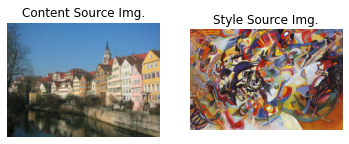

Iteración 0


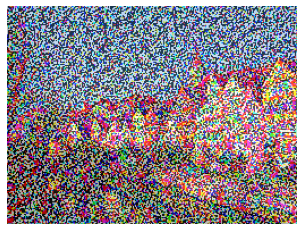

Iteración 100


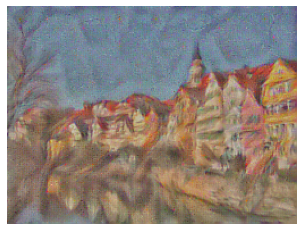

Iteracion 199


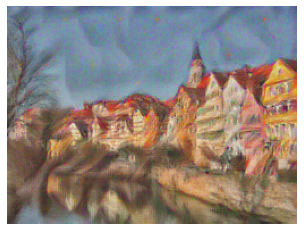

In [22]:
# Composition VII + Tubingen
params1 = {
    'content_image' : '%s/tubingen.jpg' % (STYLES_FOLDER),
    'style_image' : '%s/composition_vii.jpg' % (STYLES_FOLDER),
    'image_size' : 192,
    'style_size' : 512,
    'content_layer' : 3,
    'content_weight' : 5e-2, 
    'style_layers' : (1, 4, 6, 7),
    'style_weights' : (20000, 500, 12, 1),
    'tv_weight' : 5e-2
}

style_transfer(**params1)

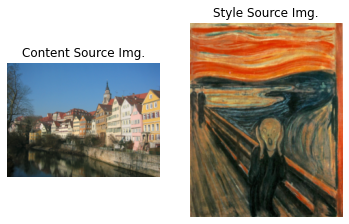

Iteración 0


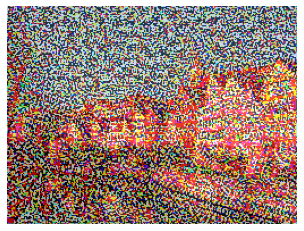

Iteración 100


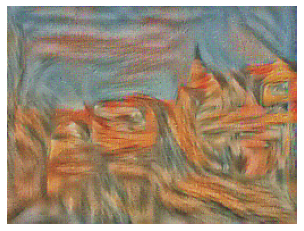

Iteracion 199


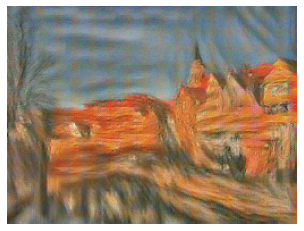

In [39]:
# Scream + Tubingen
params2 = {
    'content_image':'%s/tubingen.jpg' % (STYLES_FOLDER),
    'style_image':'%s/the_scream.jpg' % (STYLES_FOLDER),
    'image_size':192,
    'style_size':224,
    'content_layer':3,
    'content_weight':3e-2,
    'style_layers':[1, 4, 6, 7],
    'style_weights':[200000, 800, 12, 1],
    'tv_weight':2e-2
}

style_transfer(**params2)

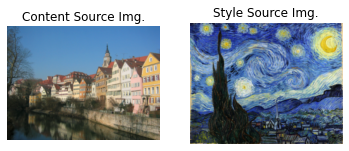

Iteración 0


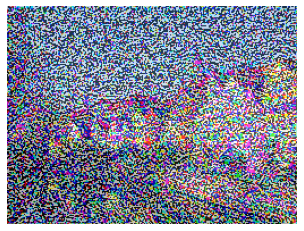

Iteración 100


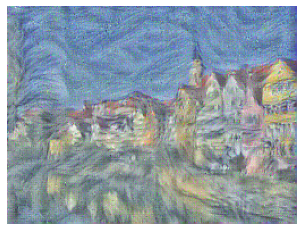

Iteracion 199


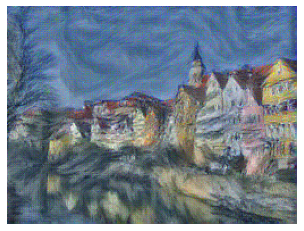

In [24]:
# Starry Night + Tubingen
params3 = {
    'content_image' : '%s/tubingen.jpg' % (STYLES_FOLDER),
    'style_image' : '%s/starry_night.jpg' % (STYLES_FOLDER),
    'image_size' : 192,
    'style_size' : 192,
    'content_layer' : 3,
    'content_weight' : 6e-2,
    'style_layers' : [1, 4, 6, 7],
    'style_weights' : [300000, 1000, 15, 3],
    'tv_weight' : 2e-2
}

style_transfer(**params3)

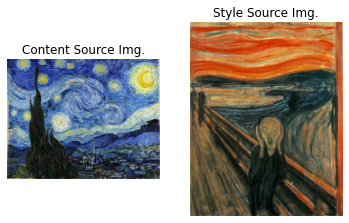

Iteración 0


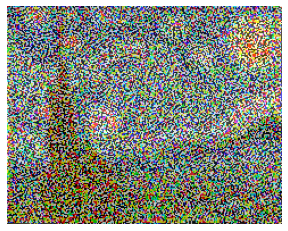

Iteración 100


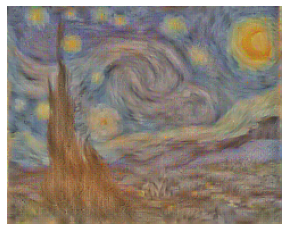

Iteracion 199


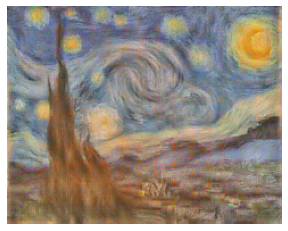

In [48]:
#Acá podés crear tu propio set de hiperparámetros y ver cómo afecta los resultados obtenidos.

# The Scream into Starry Night
params4 = {
    'content_image' : '%s/starry_night.jpg' % (STYLES_FOLDER),
    'style_image' : '%s/the_scream.jpg' % (STYLES_FOLDER),
    'image_size' : 192,
    'style_size' : 512,
    'content_layer' : 3,
    'content_weight' : 5e-2, 
    'style_layers' : (1, 4, 6, 7),
    'style_weights' : (20000, 500, 12, 1),
    'tv_weight' : 5e-2
}

style_transfer(**params4)

# Parte 3: Inversión de features

El código que desarrollaste puede hacer otra cosa interesante. En un intento por comprender los tipos de features que las redes convolucionales aprenden a reconocer, un artículo reciente "[Understanding Deep Image Representations by Inverting Them](https://arxiv.org/pdf/1412.0035.pdf)" intenta reconstruir una imagen a partir de sus mapas de activación. Podemos implementar fácilmente esta idea utilizando los gradientes de la red pre-entrenada, que es exactamente lo que hicimos anteriormente (pero con dos sets de mapas de activación diferentes).

Ahora, si configurás los pesos de estilo en 0 e inicializás la imagen de inicio con ruido aleatorio en lugar de usar la imagen de contenido, vas a reconstruir una imagen a partir de los mapas de activación de la imagen de contenido. Estás comenzando con ruido total, pero deberías terminar con algo que se parezca bastante a la imagen original.

(De manera similar, podés hacer una "síntesis de textura" desde cero si establecés el peso del contenido en 0 e inicializás la imagen inicial con ruido aleatorio, pero no te vamos a pedir que lo hagas acá).

Ejecutá la siguiente celda para probar la inversión de features.

[1] Aravindh Mahendran, Andrea Vedaldi, "Understanding Deep Image Representations by Inverting Them", CVPR 2015


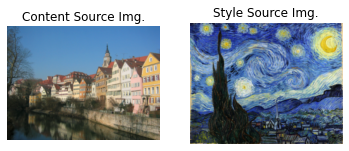

Iteración 0


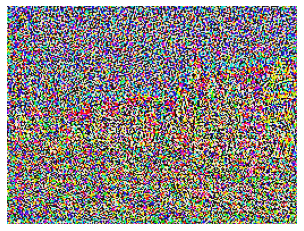

Iteración 100


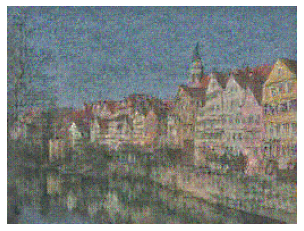

Iteracion 199


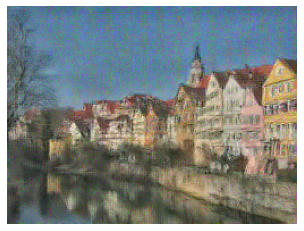

In [49]:
# Feature Inversion -- Starry Night + Tubingen
params_inv = {
    'content_image' : '%s/tubingen.jpg' % (STYLES_FOLDER),
    'style_image' : '%s/starry_night.jpg' % (STYLES_FOLDER),
    'image_size' : 192,
    'style_size' : 192,
    'content_layer' : 3,
    'content_weight' : 6e-2,
    'style_layers' : [1, 4, 6, 7],
    'style_weights' : [0, 0, 0, 0], # descartamos cualquier contribución del estilo a la pérdida
    'tv_weight' : 2e-2, 
    'init_random': True # queremos inicializar nuestra imagen para que sea aleatoria
}

style_transfer(**params_inv)